<a href="https://colab.research.google.com/github/YarinBou/Data-Streaming-Algorithms-and-Online-Learning/blob/main/ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Streaming Algorithms and Online Learning EX2

Yarin Bouzaglo
Enav sasson

## Data pre-processing
 

In [1]:
!pip install mmh3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install -U -q PyDrive

In [4]:
from google.colab import drive
import pandas as pd
import random
from tabulate import tabulate
from collections import Counter,defaultdict
from tqdm import tqdm
import math
import numpy as np
import random
import os
import random
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import mmh3
import matplotlib.pyplot as plt
from operator import itemgetter
from tqdm import tqdm

In [5]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
link = "https://drive.google.com/file/d/1IoAt94Hcwoc-oe2gKlz4lvz9IUk-ZVFT/view"

# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('xclara.csv') 
 
df = pd.read_csv('xclara.csv')

In [7]:
df.head()

,time,ipv4Src,ipv4Dest,ipProtocol,volume,sourcePort,destPort
0,2017-07-03 11:55:58.598307848,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0
1,2017-07-03 11:55:58.598311901,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0
2,2017-07-03 11:55:58.598312855,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0
3,2017-07-03 11:55:58.598313808,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0
4,2017-07-03 11:55:58.598314762,8.254.250.126,192.168.10.5,6.0,40.0,80.0,49188.0


## Count Min Sketch

In [8]:
ipv4Src_ls = df.ipv4Src.values.tolist()
ipv4Src_unique = df.ipv4Src.unique().tolist()

In [9]:
class CountMinSketchWithMorris:
  """
  Args:
            d (int): number of hash functions
            w (int): size of hash 
            s (int): size of morris array 
  """
  def __init__(self,d,w,s):
    if d <= 0 or w <= 0 or s <= 1:
      raise ValueError("d, w, s must be greater than 0, s must be greater than 1.")
    self.d = d
    self.w = w
    self.s = s

    self.p = 100000 # a (relatively) large prime

    self.a = [random.randrange(self.p) for i in range(d)]
    self.b = [random.randrange(self.p) for i in range(d)]

    self.array_init()

  def morris_array_init(self):
      return [0 for x in range(self.s)] 

  def array_init(self):
      self.array = [[self.morris_array_init() for x in range(self.w)] for y in range(self.d)] 
  
  def hash(self, x, a, b):
      return ((a*mmh3.hash(x)+b)%self.p)%self.w

  def get_hashes(self, x):
      hashes = []
      for a, b in zip(self.a, self.b):
          hashes.append(self.hash(x, a, b))
      return hashes

  def update(self, x, show=False):
    hashes = self.get_hashes(x)
    for i, h in enumerate(hashes):
      for j in range(self.s):
        self.array[i][h][j] = self.update_morris(self.array[i][h][j])
    if show:
        print(self)
  
  def update_morris(self,counter):
      if random.random() <= 2**(-counter):
        return counter + 1
      return counter

  def mean_morris_arr(self,arr):
    return np.mean(arr)

  def query(self, x):
    hashes = self.get_hashes(x)
    counts = [self.mean_morris_arr(self.array[i][h]) for i, h in enumerate(hashes)]
    output = [(2**x) - 1 for x in counts]
    return min(output)

In [10]:
size = len(df.ipv4Src)

In [11]:
ipv4Src_ls_size = df.ipv4Src.values.tolist()[0:size]
ipv4Src_unique_size = list(set(ipv4Src_ls_size))

In [12]:
counter_CountMinSketch= CountMinSketchWithMorris(20, 48320,3) 

for x in tqdm(ipv4Src_ls_size):
    counter_CountMinSketch.update(x)

100%|██████████| 11625503/11625503 [10:53<00:00, 17779.43it/s]


## Count Sketch

In [13]:
class CountSketchWithMorris:
  """
  Args:
            d (int): number of hash functions
            w (int): size of hash 
  """
  def __init__(self,d,w):
    if d <= 0 or w <= 0:
      raise ValueError("d, w, s must be greater than 0, s must be greater than 1.")
    self.d = d
    self.w = w
    self.s = 2

    self.p = 100000 # a (relatively) large prime

    self.a = [random.randrange(self.p) for i in range(d)]
    self.b = [random.randrange(self.p) for i in range(d)]

    self.array_init()

  def morris_array_init(self):
      return [0 for x in range(self.s)] 

  def array_init(self):
      self.array = [[self.morris_array_init() for x in range(self.w)] for y in range(self.d)] 
  
  def sign_hash(self, x, a, b):
      return 1 if (a*mmh3.hash(x) + b) % 2 == 0 else -1

  def hash(self, x, a, b):
      return ((a*mmh3.hash(x)+b)%self.p)%self.w

  def get_hashes(self, x):
      hashes = []
      for a, b in zip(self.a, self.b):
          hashes.append(self.hash(x, a, b))
      return hashes
    
  def get_sign_hashes(self, x):
    sign_hashes = []
    for a, b in zip(self.a, self.b):
        sign_hashes.append(self.sign_hash(x, a, b))
    return sign_hashes

  def update(self, x, show=False):
    hashes = self.get_hashes(x)
    sign_hashes = self.get_sign_hashes(x)
    for i, h in enumerate(hashes):
      if sign_hashes[i] > 0:
        # o contain the positive counter
        self.array[i][h][0] = self.update_morris(self.array[i][h][0])
      else:
        # 1 countain the negative counter
        self.array[i][h][1] = self.update_morris(self.array[i][h][1])
    if show:
        print(self)
  
  def update_morris(self,counter):
      if random.random() <= 2**(-counter):
        return counter + 1
      return counter

  def sum_up_subArr(self, x):
    hashes = self.get_hashes(x)
    sign_hashes = self.get_sign_hashes(x)
    counts = []
    for i, h in enumerate(hashes):
      counts.append(sign_hashes[i]* (self.array[i][h][0] - self.array[i][h][1]))
    return counts

    output = [(2**x) - 1 for x in counts]

  def query(self, x):
    hashes = self.get_hashes(x)
    counts = self.sum_up_subArr(x)
    output = [(2**x) - 1 for x in counts]
    return np.median(output)

In [14]:
counterSketch = CountSketchWithMorris(20, 48320) 
for x in tqdm(ipv4Src_ls_size):
    counterSketch.update(x)

100%|██████████| 11625503/11625503 [08:16<00:00, 23435.20it/s]


## Evaluation 


The evaluation is done using the following Loss function:

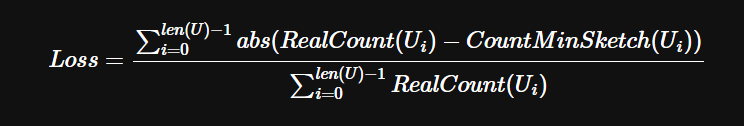

*U* : The Universe ( all the ip's)

*RealCount* : The actual count

*CountMinSketch* \ *CountSketch* : The count using the algorithm.

In [25]:
value_count_dict = df.ipv4Src.head(size).value_counts().to_dict()

In [26]:
def evaluate_Error(realCount,sketch,size):
    mse = []
    for key in realCount:
        count = sketch.query(key)
        mse.append(abs(realCount[key]-count))
    loss = sum(mse)/size
    return loss

In [27]:
pred_dict_CountMinSketch = {}
for x in ipv4Src_unique_size:
  pred_dict_CountMinSketch[x] = counter_CountMinSketch.query(x)

In [29]:
pred__dict_counterSketch = {}
for x in ipv4Src_unique_size:
  pred__dict_counterSketch[x] = counterSketch.query(x)

In [66]:
N = 14
res_pred_CountMinSketch = dict(sorted(pred_dict_CountMinSketch.items(), key = itemgetter(1), reverse = True)[:N])
res_pred_counterSketch = dict(sorted(pred__dict_counterSketch.items(), key = itemgetter(1), reverse = True)[:N])
res_true = dict(sorted(value_count_dict.items(), key = itemgetter(1), reverse = True)[:N])


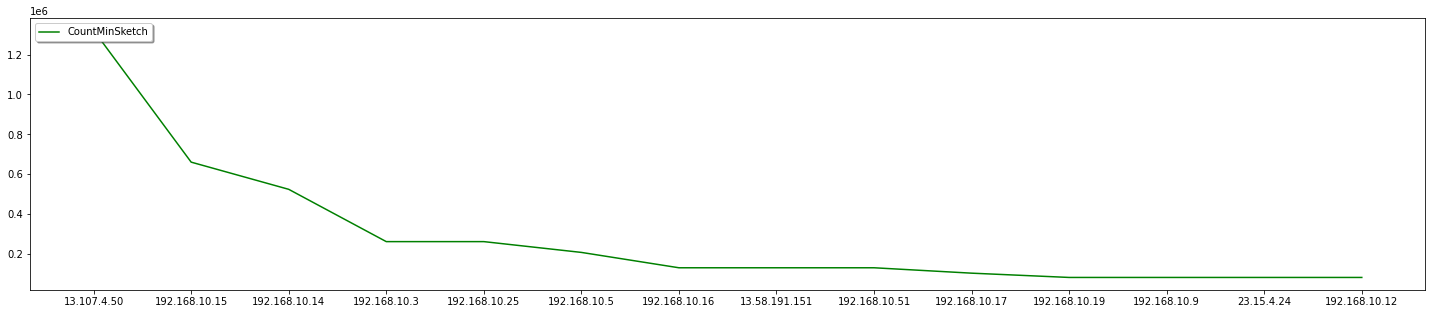

In [67]:
plt.figure(figsize=(25,5))
plt.plot(list(res_pred_CountMinSketch.keys()), list(res_pred_CountMinSketch.values()),'g',label='CountMinSketch')
legend = plt.legend(loc='upper left', shadow=True)
plt.show()

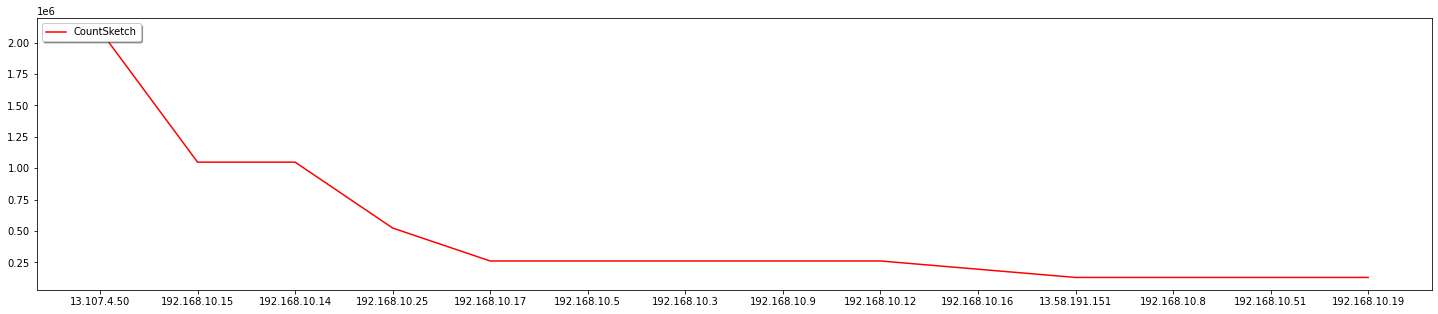

In [68]:
plt.figure(figsize=(25,5))
plt.plot(list(res_pred_counterSketch.keys()), list(res_pred_counterSketch.values()),'r',label='CountSketch')
legend = plt.legend(loc='upper left', shadow=True)
plt.show()

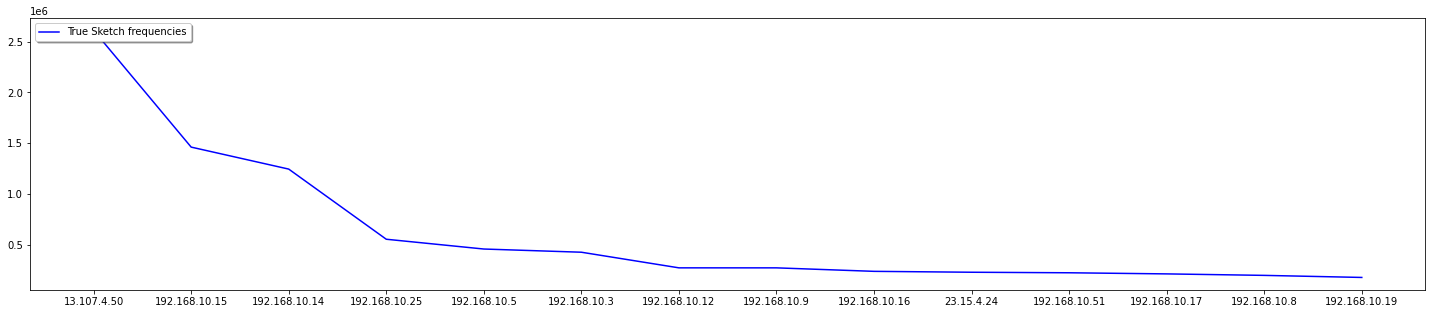

In [69]:
plt.figure(figsize=(25,5))
plt.plot(list(res_true.keys()), list(res_true.values()),'b',label='True Sketch frequencies')
legend = plt.legend(loc='upper left', shadow=True)
plt.show()

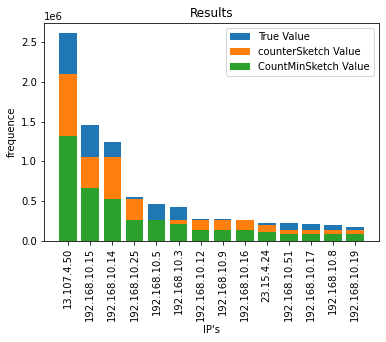

In [70]:
import matplotlib 
plt.bar(list(res_true.keys()), list(res_true.values()), label="True Value")
plt.bar(list(res_true.keys()), list(res_pred_counterSketch.values()), label="counterSketch Value")
plt.bar(list(res_true.keys()), list(res_pred_CountMinSketch.values()), label="CountMinSketch Value")


# Add labels and title
matplotlib.pyplot.xlabel("IP's")
matplotlib.pyplot.ylabel("frequence")
matplotlib.pyplot.title("Results")
matplotlib.pyplot.legend()

# Show the plot
matplotlib.pyplot.xticks(fontsize=10, rotation=90)
matplotlib.pyplot.show();

In [34]:
error_counter_CountMinSketch= evaluate_Error(value_count_dict,counter_CountMinSketch,size)
print(error_counter_CountMinSketch)

0.5480780924962441


In [35]:
error_counterSketch = evaluate_Error(value_count_dict,counterSketch,size)
print(error_counterSketch)

0.25267577669542557


**Question 1:** We have chosen our parameters with a balance between running time and accuracy in mind. We wanted to achieve a good result while also ensuring that the algorithm is suitable for a real-time streaming environment. Adding more hash functions would result in a longer running time, while reducing the number of hash functions and space would negatively affect the accuracy of the results. Our belief is that in this type of problem, it is better to "pay" with space rather than time when the accuracy needs to be close to the true value and provide a good estimate.

in particular:
- The number of hash functions used in the algorithm is 20. A larger value of hash functions will result in a more accurate estimate of item frequencies, but will also increase the running time of the algorithm. In our case,we have  a relatively small number of hash functions, which may result in less accurate estimates but faster running time.
- The Space size which is the width of the multi-dimensional array used in the algorithm. A larger value of w will result in more buckets in the array, allowing for more accurate estimates of item frequencies, but will also increase the memory required to store the data structure. In our case, with w = 48320, we have  a relatively large value for the width of the array, which may result in more accurate estimates but also requires more memory.


Overall, our choice of parameters is a balance between the running time and accuracy of the algorithm, as well as memory efficiency. It will bring a good estimate,  and it's more suitable for real-time streaming environment, but it might not be with the best accurate.

**Question 2:**The algorithm that is more close in the avarege to the true value is CountSketch.
In our implementation, the use of Morris counters with Count Sketch led to more accurate estimates in the average case, because it reduced the impact of hash collisions, which can cause errors in the estimates.
The way we chose to implement CountSketch with two different Morris arrays, one for the positive counters and one for the negative counters, helped us to achieve even greater accuracy in our estimates. This is because it allows for a more nuanced handling of positive and negative frequencies, rather than just treating them as a single value. By separating the positive and negative frequencies into different arrays, we can more effectively account for the different effects that they have on the overall estimate. This can lead to more precise estimates, particularly in scenarios where there are a large number of both positive and negative frequencies.

**Question 3.a:** The algorithm that recognize heavy hitters better is Count Min Sketch this is because it uses a multi-dimensional array, which allows for a larger number of buckets, increasing the chances of capturing the correct frequency of the items.
larger number of buckets is particularly useful when there are a few items that are much more frequent than the others the more hash functions are used, the higher the chances that the heavy-hitters will be captured by the algorithm. 
Another reason in our implementation that Count Min Sketch better  in recognizing heavy-hitters is that it uses the minimum value of the counters in the multi-dimensional array as the estimate, whereas count sketch uses the median value. The use of minimum value gives a more conservative estimate, and it is less likely to be affected by outliers, which can be present in heavy-hitters.

**Question 3.b:**The algorithm that recognize rare flow is Count sketch, when it comes to recognizing rare flows, the accuracy of the algorithm is the most important factor because rare flows often have a low frequency of occurrence and may be difficult to detect.
Counts sketch in our case is more accurate than Count-sketch, so it's a better choice for recognizing rare flows.
we noticed that any errors in the estimates can cause the algorithm to miss the true frequency of the rare flow.

**Question 4:** The closers algorithm in our implementation to the theory guarantees from the lecture is Count Sketch,
By using Morris counters instead of regular counters in both the Count Min Sketch and Count Sketch algorithms, it is possible that the accuracy of the algorithm will be improved. This will be especially true when using the Count Sketch algorithm with two arrays of Morris counters one for the positive and one for the negative. This technique allows us to keep track of both the positive and negative changes in the counters, which improves the accuracy of the algorithm by reducing the impact of underflow and overflow errors.
also by  running the algorithm multiple times with different parameters, we found that the Count Sketch algorithm in our implementation was closer to the guarantees, verify our assumptions.

**Question 5:** In our implementaion of Count Min Sketch and Count Sketch with Morris counters instead of regular counters causes to effect on both memory size and accuracy.
- Memory size - using Morris counters can result to a larger memory size because that implementaion can require for each cell multiple arrays instead of just one counter, The larger number of arrays used, the larger of memory size required.
- Accuracy - the use of Morris counters can lead to more accurate estimates, as they reduce the impact of hash collisions, which can cause errors in the estimates. 

**Bonus:** From the insight of our exercise and reading materials , we realized that choosing implementations depends, among other things, on the data you are working on, so we thought of the following idea:
In the implementation of Count Sketch we first take a subset from our data and check whether it is better to do median or minimum, we saw that each method is better for a certain type of data.

The use of the median value in Count Sketch is more robust to outliers and heavy-tailed distributions, this is because the median value is less affected by extreme values. This makes it a good choice when the data set has a high number of unique items or heavy-tailed distributions.

On the other hand, the use of the minimum value in Count Sketch is more conservative, it gives a more accurate estimate when the data set has a low number of unique items or light-tailed distributions. This is because the minimum value is less affected by errors caused by hash collisions.